In [1]:
import time
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 6
LEARNING_RATE = 0.1
MNIST_IMG_WIDTH = 28
MNIST_IMG_SIZE = MNIST_IMG_WIDTH * MNIST_IMG_WIDTH

In [3]:
train_dataset = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.MNIST('', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE)

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Running on device: {}'.format(device))

Running on device: cpu


The used formulas and definitions were derived from the [**A Practical Guide to Training Restricted Boltzmann Machines**](https://www.csrc.ac.cn/upload/file/20170703/1499052743888438.pdf) paper.

---

Hidden layer activation probability formula $p(h_{j}=1|v)$:

$p(h_{j}=1|v) = \sigma(b_{j} + \sum_{i}^{\left | v \right |}v_{i}w_{i,j})$

---

Visible layer activation probability formula $p(v_{i}=1|h)$

$p(v_{i}=1|h) = \sigma(a_{i} + \sum_{j}^{\left | h \right |}h_{j}w_{i,j})$

---

Free Energy formula where $a_{i}$ represents the visible layer bias and
$x_{j} = b_{j} + \sum_{i}^{\left |  v\right |}v_{i}w_{i,j}$ represents the hidden layer hypothesis:

$F(v) = -\sum_{i}^{\left | v \right |}a_{i}v_{i} - \sum_{j}^{\left | h\right |} log(1 + e^{x_{j}})$


In [5]:
class RestrictedBoltzmannMachine(nn.Module):

  def __init__(self, visible_n=MNIST_IMG_SIZE, hidden_n=500, k=5):
    """
    Initializer Restrived Boltzmann Machine neural network.

    Parameters:
    
    visible_n (int): Number of visible nodes.
    hidden_n  (int): Number of hidden nodes.
    k         (int): Number of Contrastive Divergance iterations.
    """
    super(RestrictedBoltzmannMachine, self).__init__()

    self.weights = nn.Parameter(torch.randn(hidden_n, visible_n)*1e-2)
    self.visible_bias = nn.Parameter(torch.zeros(visible_n))
    self.hidden_bias = nn.Parameter(torch.zeros(hidden_n))
    self.k = k

  def _get_activations(self, h):
    """
    Calculate binary activation state by comparing hypothesis to a random
    number in the interval [0, 1).
    """
    random_numbers = torch.rand(h.size())
    signs = torch.sign(h - random_numbers)
    # Convert the signature tensor to a binary {0, 1} tensor.
    return F.relu(signs)

  def _from_visible_to_hidden(self, x):
    """
    Calculate hidden layer activations given visible layer inputs.
    """
    h = torch.sigmoid(F.linear(x, self.weights, self.hidden_bias))
    hidden_activations = self._get_activations(h)
    return h, hidden_activations

  def _from_hidden_to_visible(self, x):
    """
    Calculate visible layer activations given hidden layer state.
    """
    h = torch.sigmoid(F.linear(x, self.weights.t(), self.visible_bias))
    visible_activations = self._get_activations(h)
    return h, visible_activations
  
  def forward(self, x):
    """
    Implements the Contrastive Divergance algorithm.
    """
    hidden_probabilities, hidden_activations = self._from_visible_to_hidden(x)

    # Contrastive Divergance
    activations = hidden_activations
    for i in range(self.k):
      # Reconstruct visible layer from the hidden
      visible_probabilities, visible_activations = self._from_hidden_to_visible(activations)
      # Calculate hidden activation from the newly recostructed visible nodes
      hidden_probabilities, activations = self._from_visible_to_hidden(visible_activations)

    # Return the original data and the generated one.
    return x, visible_activations

  def free_energy(self,x):
    """
    Calculates RBM's free energy given visible layer inputs.
    """
    visible_exected_energy = torch.mv(x, self.visible_bias)

    hidden_hypothesis = F.linear(x, self.weights, self.hidden_bias)
    hidden_generated_energy = hidden_hypothesis.exp().add(1).log().sum(1)
    return (-hidden_generated_energy - visible_exected_energy).mean()


In [79]:
# Initialize the Restricted Boltzmann machine
net = RestrictedBoltzmannMachine().to(device)
# Initialize Stochastic Gradient Descent optimizer
train_op = optim.SGD(net.parameters(),lr=LEARNING_RATE)

for epoch in range(10):
  loss_ = []
  start_time = time.time()
  for i, (X, y) in enumerate(train_loader):
    # Reshape X to match the RBM input format
    X = X.view(-1,784)
    sample_data = X.bernoulli().to(device)

    # Train the RBM
    original, generated = net(sample_data)
    
    # Obtain the RBM free enery loss
    loss = net.free_energy(original.to(device)) - net.free_energy(generated.to(device))
    loss_.append(loss.data)

    # Zero the gradients before computing the ones
    train_op.zero_grad()
    # Compute the gradients
    loss.backward()
    # Update the network parameters
    train_op.step()
  
  print("Training loss for {} epoch: {} took: {}s".format(epoch, torch.mean(torch.tensor((loss_))), time.time() - start_time))

Training loss for 0 epoch: -4.604414939880371 took: 47.79101777076721s
Training loss for 1 epoch: -5.860311985015869 took: 47.71075987815857s
Training loss for 2 epoch: -3.7256317138671875 took: 48.15107035636902s
Training loss for 3 epoch: -2.342672348022461 took: 48.071916818618774s
Training loss for 4 epoch: -1.4778329133987427 took: 48.015705823898315s
Training loss for 5 epoch: -0.8568824529647827 took: 47.83751702308655s
Training loss for 6 epoch: -0.4149568974971771 took: 47.85345149040222s
Training loss for 7 epoch: -0.0745152086019516 took: 47.660404443740845s
Training loss for 8 epoch: 0.19181331992149353 took: 47.971925020217896s
Training loss for 9 epoch: 0.35378456115722656 took: 47.653016805648804s


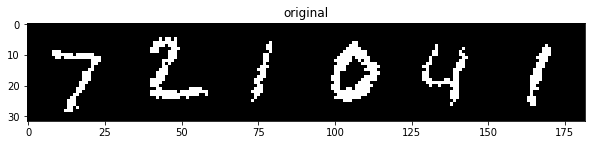

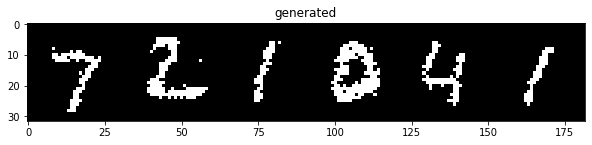

In [123]:
def display(title, data):
  plt.figure(figsize=(10, 5))
  plt.title(label=title)
  plt.imshow(np.transpose(data,(1, 2, 0)))

for _, (X, y) in enumerate(test_loader):
  X = X.view(-1,784)
  sample_data = X.bernoulli().to(device)
  original, generated = net(sample_data)
  break

display('original', make_grid(original.view(6, 1, 28, 28).data))
display('generated', make_grid(generated.view(6, 1, 28, 28).data))